# Data Processing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

### Data Importing :
The raw data is in a folder called rawdata.

And the cleaned data is in another folder called cleaned data, which is cleaned by our "TwitterDataCleaning.py".


In [2]:
NorthAmerica = pd.read_csv("cleaned data/NorthAmerica_Trends_cleaned.csv",sep = ",", header = 0)
TwitterData = NorthAmerica
len(TwitterData)
TwitterData.head()

,hashtags,location,tweet
0,NaN,NaN,zack greink ink 6 year deal with arizonadiamon...
1,NaN,NaN,report allow home shoot suspect media crew got...
2,NaN,NaN,imessag autocorrect greink grinch first time e...
3,NaN,NaN,i might person doesnt care scott weiland die
4,NaN,NaN,killer deserv respect


## Target Hastags :

we will build a data frame for the target hashtags.

It could be counted directly or set up by the top trends data from the twitter api.

### Counting.

In [3]:
ListHashtags = TwitterData.hashtags.values
listwords = []
for tag in ListHashtags:
    if type(tag) == str:
        listwords +=tag.split(" ")
     

In [4]:
#d = {x:lista.count(x) for x in lista}
from collections import Counter
tags_count=Counter(listwords)

In [5]:
import heapq
N = 10 # N is the number of most used hashtags.
index_tag = heapq.nlargest(N, tags_count.values())
print index_tag
tags_dataframe = pd.DataFrame({'hashtag':tags_count.keys(),'number': np.array(tags_count.values())   })
tags_dataframe.head()

[6535, 1135, 977, 656, 630, 606, 508, 502, 426, 422]


,hashtag,number
0,,1
1,samething,1
2,dbacksinworldseries2016,2
3,gocoug,1
4,justsayin,2


In [6]:
TargetHashtags = tags_dataframe.iloc[np.where(tags_dataframe.number.values >=index_tag[-1])]
TargetHashtags
ListTargetHashtags = list(TargetHashtags['hashtag'])

## Top trends importing.

Here we import the top trends obtained from the api of twitter.

One for hashtags, and the other for keywords.

In [7]:
HashtagsTop = pd.read_csv('cleaned data/Hashtags_cleaned1205.csv', header = 0)
KeywordsTop = pd.read_csv('cleaned data/Keywords_cleaned1205.csv', header = 0)

In [8]:
#tags_dataframe.loc[tags_dataframe['hashtag'].isin(HashtagsTop['hashtag'])]

## Build up the train set.

We extract the tweet associated with the hashtags we want to study.

Fistly, we extract the tweets by the ListTargetHashtags

In [25]:
#ListTargetHashtags = ListTargetHashtags.remove("aldubrendezvous")
ListTargetHashtags

['nationalcookieday',
 'antm',
 'theexperience10',
 'grimm',
 'muslimapartment',
 'kiisjingleball',
 'kathnielchristmasloveduets',
 'twitterawakens',
 'rdfamilyholiday']

In [26]:
def tweets_extract(twitterdata,hashtag_list):
    targetdata = twitterdata.loc[twitterdata['hashtags'].isin(hashtag_list)]
    return targetdata

In [27]:
TargetData = tweets_extract(TwitterData,ListTargetHashtags)
TargetData = TargetData.drop('location',1)
TargetData = TargetData.loc[TargetData['tweet'].notnull()]
TargetData.head()

,hashtags,tweet
8,theexperience10,this lord wow
14,twitterawakens,a lot peopl say new movi antiprequel will see ...
92,kiisjingleball,anyon wanna upgrad seat
96,muslimapartment,ohhh ikea terrifi inde
116,kiisjingleball,so ask want meet amp i start cri point scream cri


In [28]:
len(TargetData)

4597

## Bag of words

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 


In [30]:
train_data_features = vectorizer.fit_transform(TargetData.tweet.values).toarray()


In [31]:
train_data_features[0]
lable = TargetData.hashtags.values

In [32]:
from sklearn.feature_selection import SelectKBest,f_classif
Selec = SelectKBest(f_classif, k = 1000 )
train_data_features = Selec.fit_transform(train_data_features, lable)
#shape(train_data_features)

In [33]:
from sklearn.ensemble import RandomForestClassifier
N_sep = len(lable)*2/3
RF = RandomForestClassifier(n_estimators=50)
RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
print RF.score(train_data_features[N_sep:], lable[N_sep:])



0.671232876712


array([[142,   6,   8,   3,   1,   4,  36,   6,   3],
       [ 14, 173,  28,   3,  10,   3,  48,   5,   7],
       [  4,   1, 239,   0,   1,   6,  22,   3,   2],
       [  4,   2,  10,  60,   4,   1,  25,   5,   3],
       [ 10,   0,  22,   3,  53,   1,  25,   1,   7],
       [  2,   0,   6,   0,   7,  66,  12,   0,   2],
       [  3,   1,   7,   5,   1,   1, 106,   0,   4],
       [  9,   3,  17,   5,   4,   5,  41, 139,   1],
       [  3,   2,   5,   3,   0,   0,   6,   2,  51]])

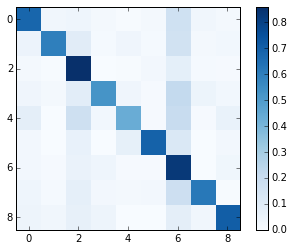

In [34]:
from sklearn.metrics import confusion_matrix
feat_pred_RF = RF.predict(train_data_features[N_sep:])
cm = confusion_matrix(lable[N_sep:],feat_pred_RF)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

## Cross Validation for RF

In [38]:
from sklearn import cross_validation
RF = RandomForestClassifier(n_estimators=50)
scores  = cross_validation.cross_val_score(RF, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.74082073  0.71922246  0.76190476  0.78138528  0.75217391  0.77608696
  0.80174292  0.75273523  0.79385965  0.76043956]
0.764037146811


In [22]:
# k_correction = []
# for n in range(100,1500,100):
#     Selec = SelectKBest(f_classif, k =1000 )
#     train_data_features = Selec.fit_transform(train_data_features, lable)
#     RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
#     k_correction.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))


In [ ]:
# plt.plot(k_correction)